# Model 3 - CNN+RNN using both geo-spatial and kinematic features

In [ ]:
!pip install datashader
!apt-get install libgeos++ libproj-dev
!pip install geoviews

In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
from google.colab import drive
drive.mount("/content/drive")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Mounted at /content/drive


In [5]:
userID = 'Sara' #@param ["Jonas", "Klara", "Sara"]

if 'j' in userID[0].lower():
  working_path = "/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/deep_project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d '/content/drive/My Drive/Colab Notebooks/02456-deep-learning-with-PyTorch-master/deep_project/DataLoaderForStudents'
    os.chdir(working_path) #Jonas connection
elif 's' in userID[0].lower():
  working_path = "/content/drive/My Drive/Deep Learning/project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d "/content/drive/My Drive/Deep Learning/project/DataLoaderForStudents"
    os.chdir(working_path) #Sara connection
else:
  working_path = "/content/drive/My Drive/project/DataLoaderForStudents"
  try:
    os.chdir(f'{working_path}')
  except:
    print('Download and unzip folder')
    !wget https://staticavantipw.s3.eu-west-1.amazonaws.com/DeepLearning2020data/MMM_DataLoaderForStudents.zip
    !unzip '/content/MMM_DataLoaderForStudents.zip' -d "/content/drive/My Drive/project/DataLoaderForStudents"
    os.chdir(working_path) #Klara connection

In [6]:
sys.path.append(f'{working_path}/MMM_DataLoaderForStudents/src')
from data_utils_conda import *
clear_output(wait=False)

In [7]:
from modelClass2Ch9 import *

### Load train, validation and test data

In [8]:
random.seed(123)
user_train, user_val, user_test = train, val, test = train_test_data_split(Random = True)
user_train = [user for user in user_train if user!=4]
user_test = [user for user in user_test if user!=9]
print("We train on users {}\n we validate on users {}\n and we test on users {}".format(user_train,user_val,user_test))

We train on users [0, 1, 6, 10, 11, 8, 3]
 we validate on users [2]
 and we test on users [5, 7]


### Set time interval and speed cut off

In [9]:
# get data
dataset = decompress_pickle(f'{working_path}/MMM_DataLoaderForStudents/Pickle/dataSet.pbz2')
dataset.rename(columns = {"label": "label2"})
labelMeaning = pd.read_csv(f'{working_path}/MMM_DataLoaderForStudents/UID-MMM-labels.csv').drop(columns='Unnamed: 0')[['stop','mode','howTravelled','purpose','mainActivity']]
labelMeaning.head()

,stop,mode,howTravelled,purpose,mainActivity
0,1,0,-100,14,Work
1,2,5,Foot,0,-100
2,1,0,-100,0,-100
3,2,5,Foot,0,-100
4,1,0,-100,14,Work


In [10]:
# change index to 0/1
dataset.label2 = dataset.label2-1

In [11]:
# image_ix:             ???
# segment_point_count:  length of minimum seq to infer on
# segment_ix:           step in trip
# segment_id:           where we are on grid ? (each sequence is split by cutoff_speed/time and labelled)
# tod:                  ???
dataset.head()

,user,ts,image_ix,label2,labelP,labelM,delta_t,delta_d,bearing,speed,tod,segment_id,segment_ix,segment_point_count
0,1,2018-06-25 09:57:31+00:00,1,0,3,0,671.0,7.751420,-1.856730,0.011552,1,1,0,1
1,1,2018-06-25 09:58:43+00:00,4,1,0,4,72.0,133.415960,-2.005347,1.852999,1,2,0,1
2,1,2018-06-25 09:58:44+00:00,5,1,0,4,1.0,57.104376,-1.252389,57.104376,1,3,0,1
3,1,2018-06-25 09:58:45+00:00,6,1,0,4,1.0,47.314571,1.864483,47.314571,1,4,0,606
4,1,2018-06-25 09:58:46+00:00,7,1,0,4,1.0,7.512082,2.876788,7.512082,1,4,1,606


In [12]:
data_train = pd.concat([dataset[(dataset.user==tr)] for tr in user_train]).reset_index(drop=True)
data_val = pd.concat([dataset[(dataset.user==va)] for va in user_val]).reset_index(drop=True)
#data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test if te != 4]).reset_index(drop=True)
# The following should be loaded after training phase. You can add the user 4 here, just fot technical limitations. It should be mentioned in the report.
#data_test = pd.concat([dataset[(dataset.user==te)] for te in user_test+[4] if 4 in user_test else user_test]).reset_index(drop=True)

In [13]:
data_train = data_train[data_train['segment_ix'] >= filter_seq]
data_val = data_val[data_val['segment_ix'] >= filter_seq]
#data_test = data_test[data_test['segment_ix'] >= 5]


### Load precomputed image frames

In [14]:
image_data = {}
#for user_id in user_train + user_val + user_test:
for user_id in user_train + user_val:
    #if user_id != 4: #This is not relevant for the test partition. Again, this is for technical limitations, and for consistency with the above fix.
    image_data[user_id] = np.stack(decompress_pickle(working_path+f'/MMM_DataLoaderForStudents/Pickle/images_list_{user_id}.pbz2'), axis = 0).astype(float)
    print(image_data[user_id].shape[0])

17990
17990
2344
86277
28845
112
83326
20132


## Example Input/output data from ``TensorDataset``

In [15]:
demo_dataset = ImageTensorDataset(data_train, image_data)

for X_img, X_seq, X_tod, y in torch.utils.data.DataLoader(demo_dataset, batch_size=2, shuffle=True):
    print('X_img :', X_img.shape)
    print(X_img[0, :, :, 0])
    print('X_seq :', X_seq.shape)
    print(X_seq[0, :])
    print('X_tod :', X_tod.shape)
    print(X_tod[0])
    print('y :', y.shape)
    print(y[0])
    break;

X_img : torch.Size([2, 9, 9, 11])
tensor([[0., 0., 0., 1., 0., 1., 1., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 0., 0., 0.],
        [1., 0., 1., 0., 1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=torch.float64)
X_seq : torch.Size([2, 6, 2])
tensor([[ 1.6309, -3.1028],
        [ 1.5932,  2.7253],
        [ 2.2748,  2.2660],
        [ 3.2642,  2.2522],
        [ 4.4586,  2.1413],
        [ 5.8403,  1.8598]], dtype=torch.float64)
X_tod : torch.Size([2, 5])
tensor([0., 1., 0., 0., 0.], dtype=torch.float64)
y : torch.Size([2])
tensor(1)


#### Class weights

In [16]:
class_weights = [(data_train[label] == 0).sum()/(data_train[label] == x).sum() for x in range(NUM_CLASSES)]
#class_weights[-2:] = [np.max(class_weights[:-2]), np.max(class_weights[:-2])]
class_weights

[1.0, 3.0267842886795466]

#### Define Data Loaders

In [17]:
train_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_train, image_data), batch_size=BATCH_SIZE, shuffle=True, num_workers=8) 
val_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_val, image_data), batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
#test_dataloader = torch.utils.data.DataLoader(ImageTensorDataset(data_test, image_data), batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

In [18]:
#data_train

#### Define model, optimizer and loss

In [19]:
#device = torch.device(0) # PyTorch v0.4.0
model = CnnNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-10)
criterion = nn.CrossEntropyLoss(weight = torch.Tensor(class_weights).cuda())

#### Number of parameters

In [20]:
#np.sum([np.product(x.cpu().detach().numpy().shape) for x in model.parameters()])

#### Test input/output of model

In [21]:
print(X_img.shape)
imagex = X_img #(X_img[:,:,:,0]+X_img[:,:,:,1]+X_img[:,:,:,2]+X_img[:,:,:,3]+X_img[:,:,:,9]).reshape(2,9,9,1)
print(imagex.shape)

out = model(imagex.float().cuda()#.to(device, dtype=torch.float)
, X_seq.float().cuda()#.to(device, dtype=torch.float)
, X_tod.float().cuda()#.to(device, dtype=torch.float)
)
print(out.shape)

torch.Size([2, 9, 9, 11])
torch.Size([2, 9, 9, 11])
torch.Size([2, 2])


In [22]:
phases = {
    'train': {
        'dataloader': train_dataloader,
        'is_training': True,
    },
    'validation': {
        'dataloader': val_dataloader,
        'is_training': False,
    }
}

### Train / Validation loop

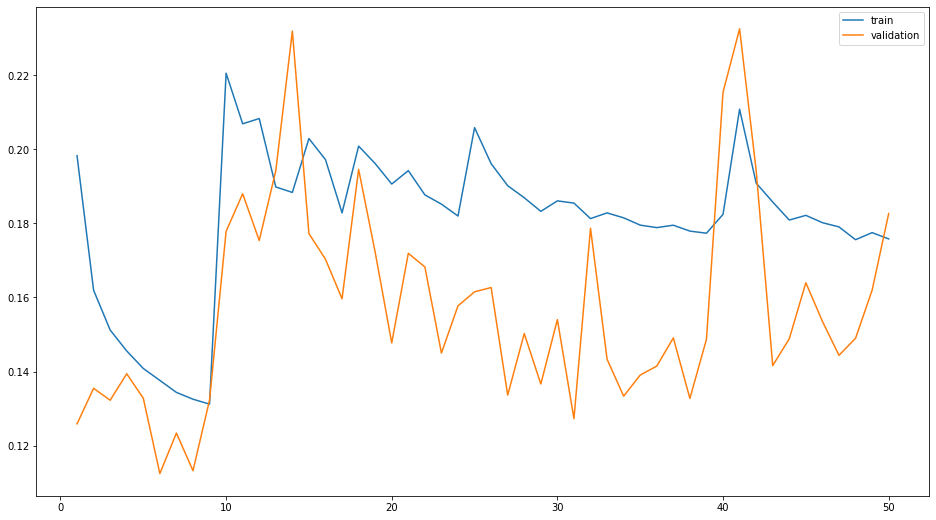

average epoch duration 9.254558186531067
stdev epoch duration 0.4727335689582203
Training lasted 462.72790932655334


In [23]:
#CUDA_LAUNCH_BLOCKING=1 
epochComputationTime =  []
for epoch in range(1, NUM_EPOCH + 1):
    
    for phase_name, phase in phases.items():
        epoach_loss = 0.0
                
        phase_is_training = phase['is_training']
        phase_dataloader = phase['dataloader']
        model.train(phase_is_training)
        
        # Ajust and save the learning rate in the phase dict
        if phase_is_training:
            startEpoch = time.time()
            lr = adjust_lr(optimizer, epoch)
            phase.setdefault('lr', []).append(lr)
            
        # Iterate over each bath in the phase
        for i, batch in enumerate(phase_dataloader, 1):
            #print(i)
            #print(batch[0].shape)
            X_img, X_seq, X_tod, y = batch 
            #X_img = (X_img0[:,:,:,0]+X_img0[:,:,:,1]+X_img0[:,:,:,2]+X_img0[:,:,:,3]+X_img0[:,:,:,9]).reshape(X_img0.size()[0],9,9,1)
            #print(X_img.size(),X_seq.shape,X_tod.shape)

            X_img = X_img.float().cuda()#.to(device, dtype=torch.float)
            X_seq = X_seq.float().cuda()#.to(device, dtype=torch.float)
            X_tod = X_tod.float().cuda()#.to(device, dtype=torch.float)
            y = y.long().cuda()#.to(device, dtype=torch.int64)

            with torch.set_grad_enabled(phase_is_training):
                out = model(X_img, X_seq, X_tod)
                loss = criterion(out, y)

            if phase_is_training:
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.4)
                optimizer.step()
        
            epoach_loss += loss.item()
        
        # Save the loss for the epoch in the phase dict
        phase.setdefault('loss', []).append(epoach_loss/i)
        if phase_is_training:
            endEpoch = time.time()
            epochComputationTime.append(endEpoch-startEpoch)
            
        
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize = (16, 9))
    #ax.set_yscale('log')
    
    for phase_name, phase in phases.items():
        ax.plot(np.arange(1, epoch + 1), phase['loss'], label = phase_name)        
    
    ax.legend()
    plt.show();
    print(f'average epoch duration {np.mean(epochComputationTime)}')
    print(f'stdev epoch duration {np.std(epochComputationTime)}')
    print(f'Training lasted {np.sum(epochComputationTime)}')

In [24]:
torch.save(model.state_dict(), os.getcwd()+"/trained_model_label2_ch9_without_49")

[autoreload of modelClass2Ch9 failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
RecursionError: maximum recursion depth exceeded
]


### Validation/Test prediction loop

In [ ]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    phase_dataloader = phase['dataloader']
    phase['predicted'] = []
    phase['true'] = []
    
    for i, batch in enumerate(phase_dataloader, 1):
        X_img, X_seq, X_tod, y = batch
        #X_img = (X_img0[:,:,:,0]+X_img0[:,:,:,1]+X_img0[:,:,:,2]+X_img0[:,:,:,3]+X_img0[:,:,:,9]).reshape(X_img0.size()[0],9,9,1)

        phase['true'].extend(list(y.numpy()))
        
        X_img = X_img.float().cuda()#.to(device, dtype=torch.float)
        X_seq = X_seq.float().cuda()#.to(device, dtype=torch.float)
        X_tod = X_tod.float().cuda()#.to(device, dtype=torch.float)
        y = y.float().cuda()#.to(device, dtype=torch.float)
        
        with torch.no_grad():
            out = model(X_img, X_seq, X_tod)
            probability, predicted = torch.max(out, 1)
            
        phase['predicted'].extend(list(predicted.cpu().numpy()))        

### Final results

In [ ]:
for phase_name, phase in phases.items():
    if phase['is_training']: 
        continue
    
    print(phase_name)
    print(classification_report(phase['true'], phase['predicted'], target_names = ['0','1']))

validation
              precision    recall  f1-score   support

           0       0.31      0.34      0.33       779
           1       0.96      0.95      0.95     11558

    accuracy                           0.91     12337
   macro avg       0.63      0.64      0.64     12337
weighted avg       0.91      0.91      0.91     12337

